# Train

In [ ]:
from google.colab import drive
drive.mount('drive')

THE MODELS WILL BE SAVED IN A FOLDER CALLED "serialized-models". 

BE SURE YOU HAVE THIS FOLDER CREATED.

## Download + prepare data


In [ ]:
# Links:
# https://drive.google.com/drive/folders/11Vz0fqHS2rXDb5pprgTjpD7S2BAJhi1P

  # https://drive.google.com/file/d/107vh6Tibfs1p8pbc3gql-eVwxiqCD2o4/view
  # https://drive.google.com/file/d/1O89DVCoWsMhrIF3G8-wMOJ0h7LukmMdP/view
  # https://drive.google.com/file/d/1E23HCNL-v9c54Wnzkm9yippBW8IaLUXp/view
  # https://drive.google.com/file/d/1-LFFkFKNuyBO1sjkM4t_AArIXr3JAOyl/view

# IDs:
# 128: 107vh6Tibfs1p8pbc3gql-eVwxiqCD2o4
# 256: 1O89DVCoWsMhrIF3G8-wMOJ0h7LukmMdP
# 512: 1E23HCNL-v9c54Wnzkm9yippBW8IaLUXp
# 1024: 1-LFFkFKNuyBO1sjkM4t_AArIXr3JAOyl

In [ ]:
!mkdir -p data/downloads/manual/celeb_a_hq

In [ ]:
%%writefile data/downloads/manual/celeb_a_hq/main.py
# adapted from https://unix.stackexchange.com/questions/146264/is-there-a-way-to-convert-a-zip-to-a-tar-without-extracting-it-to-the-filesystem
import sys
import os
from zipfile import ZipFile
import tarfile
import time

def main(ifn, ofn, output_test_file_name):
    import numpy as np
    np.random.seed(0)
    indices = np.concatenate(
        (np.array([4604,1224,18790,4923,16943]), # final indices in the 3000 img folder: 445, 104, 1839, 480, 1665
        np.random.choice(range(1,30001),replace=False,size=3000-5))
    )
    np.random.seed()
    tupleEndsWith = tuple(["/"+"{:05d}".format(index) + ".jpg" for index in indices])

    with ZipFile(ifn) as zipf:
      with tarfile.open(output_test_file_name, 'w') as test_tarf:
        with tarfile.open(ofn, 'w') as tarf:
            for zip_info in zipf.infolist():
                if zip_info.filename.endswith("/"):
                    continue
                # if zip_info.filename.endswith("00001.jpg") or\
                #   zip_info.filename.endswith("00002.jpg") or\
                #   zip_info.filename.endswith("00003.jpg") or\
                #   zip_info.filename.endswith("00004.jpg") or\
                #   zip_info.filename.endswith("00005.jpg") or\
                #   zip_info.filename.endswith("00006.jpg") or\
                #   zip_info.filename.endswith("00007.jpg") or\
                #   zip_info.filename.endswith("00008.jpg") or\
                #   zip_info.filename.endswith("00009.jpg") or\
                #   zip_info.filename.endswith("00010.jpg"):
                #     continue
                # print(zip_info.filename, zip_info.file_size)
                tar_info = tarfile.TarInfo(name=zip_info.filename)
                tar_info.size = zip_info.file_size
                tar_info.mtime = time.mktime(tuple(list(zip_info.date_time) +
                                         [-1, -1, -1]))
                if zip_info.filename.endswith(tupleEndsWith):
                  with zipf.open(zip_info.filename) as myfile:
                    test_tarf.addfile(
                        tarinfo=tar_info,
                        fileobj=myfile
                    )
                else:
                  with zipf.open(zip_info.filename) as myfile:
                    tarf.addfile(
                        tarinfo=tar_info,
                        fileobj=myfile
                    )

input_file_name = sys.argv[1]
output_train_file_name = os.path.splitext(input_file_name)[0] + '.tar'
output_test_file_name = os.path.splitext(input_file_name)[0] + '_test.tar'

main(input_file_name, output_train_file_name,output_test_file_name)

Writing data/downloads/manual/celeb_a_hq/main.py


In [ ]:
%%bash
# adaptation from https://medium.com/@acpanjan/download-google-drive-files-using-wget-3c2c025a8b99
cd data/downloads/manual/celeb_a_hq

d="1024" #@param ["128", "256", "512", "1024"]

case $d in
  128)
    FILEID="107vh6Tibfs1p8pbc3gql-eVwxiqCD2o4"
    ;;

  256)
    FILEID="1O89DVCoWsMhrIF3G8-wMOJ0h7LukmMdP"
    ;;

  512)
    FILEID="1E23HCNL-v9c54Wnzkm9yippBW8IaLUXp"
    ;;

  1024)
    FILEID="1-LFFkFKNuyBO1sjkM4t_AArIXr3JAOyl"
    ;;

  *)
    echo -n "ERROR"
    ;;
esac
FILENAME="data${d}x${d}.zip"
COMMAND=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate "https://docs.google.com/uc?export=download&id=${FILEID}" -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')
wget --quiet --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=${COMMAND}&id=${FILEID}" -O ${FILENAME} && rm -rf /tmp/cookies.txt
python main.py ${FILENAME}

## Access data in TFDS

In [ ]:
# def goThrough(tfDataset,batchSize,numberOfInstances):
#   import tensorflow.compat.v1 as tf
#   import tensorflow_datasets as tfds

#   tf.disable_eager_execution()

#   nBatches = int(numberOfInstances/batchSize)

#   train_it = tfDataset.batch(batchSize).repeat()

#   iterator = train_it.make_initializable_iterator()
#   # extract an element
#   next_element = iterator.get_next()

#   init_op = tf.global_variables_initializer()

#   sess = tf.Session()
#   sess.run(init_op)
#   sess.run(iterator.initializer)
#   for batchNumber in range(nBatches):
#     yield sess.run(next_element)
#   sess.close()

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
d="1024"#@param ["128", "256", "512", "1024"]
# Construct a tf.data.Dataset
ds = tfds.load('celeb_a_hq/'+d, split="train", data_dir = './data')

Shuffling and writing examples to ./data/celeb_a_hq/1024/2.0.0.incompleteZZ9DWN/celeb_a_hq-train.tfrecord



Dataset celeb_a_hq downloaded and prepared to ./data/celeb_a_hq/1024/2.0.0. Subsequent calls will reuse this data.


In [ ]:
# import matplotlib.pyplot as plt
# for x in ds:
#   plt.imshow(x["image"])
#   plt.figure()

In [ ]:
# import tensorflow.compat.v1 as tf
# tf.disable_eager_execution()
# import tensorflow_datasets as tfds
# import matplotlib.pyplot as plt
# d="1024"#@param ["128", "256", "512", "1024"]
# # Construct a tf.data.Dataset
# ds = tfds.load('celeb_a_hq/'+d, split="train", data_dir = './data')

## Serialize/Deserialize

In [ ]:
import pickle
def serialize(fitDistribution,dataName,distributionName,k,location='drive/My Drive/serialized-models/'):
  # distributionName in {"PixelCnn","Normal" (only for colored images), "NormalChannels","MatrixNormalChannels","MatrixNormalChannelsFaster"}
  if distributionName == "PixelCnn":
    fitDistribution = list(fitDistribution)
    fitDistribution[3],fitDistribution[4],fitDistribution[5]=None,None,None
  filename = location+'{}_{}_{}.pkl'.format(dataName, distributionName, k)
  pickle.dump(fitDistribution,open(filename,'wb'))

def deserialize(dataName,distributionName,k,location='drive/My Drive/serialized-models/'):
  filename = location+'{}_{}_{}.pkl'.format(dataName, distributionName, k)
  fitDistribution = pickle.load(open(filename,"rb"))
  if distributionName == "Normal":
    fitDistribution  = [fitDistribution]
  return fitDistribution

## Code

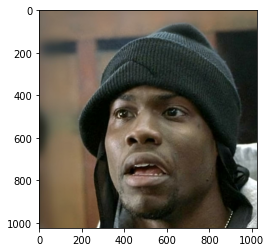

In [ ]:
# import matplotlib.pyplot as plt
# for x in ds:
#   plt.imshow((x['image'].numpy()))
#   break

In [ ]:
# from PIL import Image
# iterator = goThroughImage(tfDataset=ds,batchSize=1000,numberOfInstances=30000)
# counter = 0
# for batch in iterator:
#   for X in batch:
#     if counter >= 30000-10:
#       im = Image.fromarray(X)
#       im.save("{}.jpg".format(counter))
#     counter+=1

In [ ]:
# import numpy as np
# import tensorflow.compat.v1 as tf
# tf.disable_eager_execution()

In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
# from scipy.stats import matrix_normal
class FitMatrixNormalDistributionBigData:
  def __init__(self,tfDataset,numberOfInstances,batchSize,k,maxNumberOfEpochs = 10, threshold = 1e-6, ridge = 0.0):
    self.k = k
    self.maxNumberOfEpochs = maxNumberOfEpochs
    self.threshold = threshold
    self.ridge=ridge
    self.tfDataset = tfDataset
    self.numberOfInstances = numberOfInstances
    self.batchSize = batchSize
  
  def fit(self,maxEmIterations=100):
    if self.k == 1:
      return self._simpleAlgorithm()
    return self._emAlgorithm(maxEmIterations)

  def _simpleAlgorithm(self):
    nBatches = int(self.numberOfInstances/self.batchSize)

    print("initializing...")
    
    def image_preprocess(x):
        x["image"] = tf.cast(x["image"]/np.float32(255.0), tf.float32)
        return x["image"]

    iterator = self.tfDataset.map(image_preprocess).batch(self.batchSize)
    M = [0,0,0]
    U = [0,0,0]
    V = [0,0,0]
    counter = 0
    for batch in iterator:
      # if counter == nBatches:
      #   break
      print(counter)
      counter+=1
      batch = batch.numpy()
      # print(batch.shape)
      for i in range(3):
        
        auxU=batch[...,i].reshape(-1,batch[...,i].shape[2])
        auxU=tf.linalg.matmul(auxU.T,auxU)
        U[i]+=auxU/self.numberOfInstances

        auxV=batch[...,i].swapaxes(1,2).reshape(-1,batch[...,i].shape[1])
        auxV=tf.linalg.matmul(auxV.T,auxV)
        V[i]+=auxV/self.numberOfInstances

        M[i] = M[i]+tf.math.reduce_mean(batch[...,i],axis=0)/nBatches

    for i in range(3):
      auxU = M[i].numpy().mean(axis=0)[...,np.newaxis]
      U[i] = U[i] - tf.linalg.matmul(auxU,auxU.T) + self.ridge*np.identity(M[i].shape[0]).astype(np.float32) # not used!

      auxV = M[i].numpy().mean(axis=1)[...,np.newaxis]
      V[i] = V[i] - tf.linalg.matmul(auxV,auxV.T) + self.ridge*np.identity(M[i].shape[1]).astype(np.float32)

    print("done initializing")

    for epoch in range(self.maxNumberOfEpochs):
      print(epoch)
      oldU = U
      oldV = V
      U = [0,0,0]
      V_inv = [tf.linalg.inv(V[0]),tf.linalg.inv(V[1]),tf.linalg.inv(V[2])]
      iterator = self.tfDataset.map(image_preprocess).batch(self.batchSize)
      counter=0
      for batch in iterator:
        # if counter == nBatches:
        #   break
        print(counter)
        counter+=1
        for X in batch:
          for i in range(3):
            U[i] += 1/(M[i].shape[1]*self.numberOfInstances)*tf.linalg.matmul(X[...,i] - M[i],
                                tf.linalg.matmul(
                                    V_inv[i],
                                    tf.transpose(X[...,i] - M[i]))) 
      for i in range(3):
        U[i] = U[i] + self.ridge*np.identity(M[i].shape[0]).astype(np.float32)
      V = [0,0,0]
      U_inv = [tf.linalg.inv(U[0]),tf.linalg.inv(U[1]),tf.linalg.inv(U[2])]
      iterator = self.tfDataset.map(image_preprocess).batch(self.batchSize)
      counter=0
      for batch in iterator:
        # if counter == nBatches:
        #   break
        print(counter)
        counter+=1
        for X in batch:
          for i in range(3):
            V[i] += 1/(M[i].shape[0]*self.numberOfInstances)*tf.linalg.matmul(tf.transpose(X[...,i] - M[i]),
                                                          tf.linalg.matmul(
                                                              U_inv[i],
                                                              X[...,i] - M[i]
                                                          ))
      for i in range(3):
        V[i] = V[i] + self.ridge*np.identity(M[i].shape[1]).astype(np.float32)
      
      toBreak = False
      for i in range(3):
        error1 = np.linalg.norm(U[i].numpy() - oldU[i].numpy())/np.linalg.norm(oldU[i].numpy())
        error2 = np.linalg.norm(V[i].numpy() - oldV[i].numpy())/np.linalg.norm(oldV[i].numpy())
        print(error1)
        print(error2)
        if error1 < self.threshold and error2 < self.threshold:
          toBreak = True
          break
      if toBreak:
        break
      serialize([(np.array([1.0],dtype=np.float32),np.array([M[i].numpy()],dtype=np.float32),np.array([U[i].numpy()],dtype=np.float32),np.array([V[i].numpy()],dtype=np.float32)) for i in range(3)],
                dataName,distributionName,str(k)+"_{}".format(epoch))
    return [(np.array([1.0],dtype=np.float32),np.array([M[i].numpy()],dtype=np.float32),np.array([U[i].numpy()],dtype=np.float32),np.array([V[i].numpy()],dtype=np.float32)) for i in range(3)]
  
  # def _emAlgorithm(self,maxEmIterations):
  #   data = self.data
  #   n = data.shape[0]
  #   # initialization
  #   pis = [None]*self.k
  #   Ms = [None]*self.k
  #   Us = [None]*self.k
  #   Vs = [None]*self.k
  #   simpleU = np.cov(data.reshape(-1,data.shape[2]).T) + self.ridge*np.identity(data.shape[1]).astype(np.float32) # not used!
  #   simpleV = np.cov(data.swapaxes(1,2).reshape(-1,data.shape[1]).T) + self.ridge*np.identity(data.shape[2]).astype(np.float32)
  #   if 'bugSwap' not in globals():
  #     aux = simpleU
  #     simpleU = simpleV
  #     simpleV = aux
  #   # E step
  #   E = np.random.rand(n,self.k)
  #   for i in range(n):
  #     E[i,:] = E[i,:]/np.sum(E[i,:])# matrix_normal.pdf(data[i,:,:], mean=M, rowcov=U, colcov=V)
  #   for iteration in range(maxEmIterations):
  #     print("EM Iteration: ",iteration)
  #     # M step
  #     for j in range(self.k):
  #       pis[j] = np.mean(E[:,j])
  #       Ms[j] = np.average(data,axis=0,weights=E[:,j])
  #       # print(data.reshape(-1,data.shape[2]).T.shape)
  #       # print(E[:,j].shape)
  #       # Us[j] = np.cov(data.reshape(-1,data.shape[2]).T,aweights=E[:,j]) + self.ridge*np.identity(Ms[j].shape[0]).astype(np.float32) # not used!
  #       # Vs[j] = np.cov(data.swapaxes(1,2).reshape(-1,data.shape[1]).T,aweights=E[:,j]) + self.ridge*np.identity(Ms[j].shape[1]).astype(np.float32)
  #       if iteration == 0:
  #         Us[j] = simpleU
  #         Vs[j] = simpleV
  #       print("\tcluster ",j)
  #       for epoch in range(self.maxNumberOfEpochs):
  #         print("\tU/V Epoch: ", epoch)
  #         oldU = Us[j]
  #         oldV = Vs[j]
  #         U = 0
  #         V_inv = np.linalg.inv(Vs[j])
  #         auxSum = np.sum(E[:,j])
  #         for i in range(data.shape[0]):
  #           X = data[i,:,:]
  #           U += 1/(data.shape[2]*auxSum) * E[i,j] * np.matmul(X - Ms[j],
  #                               np.matmul(
  #                                   V_inv,
  #                                   (X - Ms[j]).T)) + self.ridge*np.identity(Ms[j].shape[0]).astype(np.float32)
  #         V = 0
  #         U_inv = np.linalg.inv(U)
  #         for i in range(data.shape[0]):
  #           X = data[i,:,:]
  #           V += 1/(data.shape[1]*auxSum)*E[i,j]*np.matmul((X - Ms[j]).T,
  #                                                         np.matmul(
  #                                                             U_inv,
  #                                                             X - Ms[j]
  #                                                         )) 
  #           + self.ridge*np.identity(Ms[j].shape[1]).astype(np.float32)
  #         Us[j]=U
  #         Vs[j]=V
  #         error1 = np.linalg.norm(U - oldU)/np.linalg.norm(oldU)
  #         error2 = np.linalg.norm(V - oldV)/np.linalg.norm(oldV)
  #         print("\t\t",error1)
  #         print("\t\t",error2)
  #         if error1 < self.threshold and error2 < self.threshold:
  #           print("\tU/V: exited via threshold")
  #           break
  #       # print("\tU/V: exited via maxIterations")
  #     newParameters = np.concatenate([np.array(pis),np.array(Ms).reshape((-1,)),np.array(Us).reshape((-1,)),np.array(Vs).reshape((-1,))])
  #     if iteration != 0:
  #       error = np.linalg.norm(newParameters - oldParameters)/np.linalg.norm(oldParameters)
  #       print(error)
  #       if error < self.threshold:
  #         print("exited via threshold")
  #         break
  #     oldParameters = newParameters
  #   # print("exited via maxIterations")
        
  #   return np.array(pis,dtype=np.float32),np.array(Ms,dtype=np.float32),np.array(Us,dtype=np.float32),np.array(Vs,dtype=np.float32)
  #   # gmm = mixture.GaussianMixture(n_components=self.k)
  #   # gmm.fit(self.data)
  #   # for i in range(self.k):
  #   #   gmm.covariances_[i] = gmm.covariances_[i] + np.identity(self.data.shape[1]) * self.ridge
  #   # return gmm.weights_.astype(np.float32),gmm.means_.astype(np.float32),gmm.covariances_.astype(np.float32)

# r = FitMatrixNormalDistribution(
#     tfDataset,numberOfInstances=100,batchSize=10,1,
#     maxNumberOfEpochs = 0, # faster, approximate
#     threshold = 1e-6, 
#     ridge = 1e-6
# ).fit() 

# fitMatrixNormalDistribution = FitMatrixNormalDistribution(
#     data,1,
#     maxNumberOfEpochs = 10, 
#     threshold = 1e-6, 
#     ridge = 1e-6
# )
# r12 = fitMatrixNormalDistribution.fit()

# fitMatrixNormalDistribution = FitMatrixNormalDistribution(
#     data,2,
#     maxNumberOfEpochs = 1, # faster (very fast!!!), approximate
#     threshold = 1e-6, 
#     ridge = 1e-6
# )
# r21 = fitMatrixNormalDistribution.fit(maxEmIterations=2) 

# fitMatrixNormalDistribution = FitMatrixNormalDistribution(
#     data,2,
#     maxNumberOfEpochs = 10, 
#     threshold = 1e-6, 
#     ridge = 1e-6
# )
# r22 = fitMatrixNormalDistribution.fit(maxEmIterations=2)

## Run

In [ ]:
dataName = "CelebaHq"

In [ ]:
distributionName = "MatrixNormalChannelsFaster"

In [ ]:
%%time
k = 1
r = FitMatrixNormalDistributionBigData(
    tfDataset=ds,numberOfInstances=27000,batchSize=150,k=k,
    maxNumberOfEpochs = 0, # faster, approximate
    threshold = 1e-6, 
    ridge = 1e-6
).fit()
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

initializing...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
done initializing
Done  CelebaHq MatrixNormalChannelsFaster 1
CPU times: user 1h 16min 1s, sys: 1min 41s, total: 1h 17min 42s
Wall time: 1h 10min 55s


In [ ]:
distributionName = "MatrixNormalChannels"

In [ ]:
%%time
k = 1
r = FitMatrixNormalDistributionBigData(
    tfDataset=ds,numberOfInstances=27000,batchSize=150,k=k,
    maxNumberOfEpochs = 10,
    threshold = 1e-6, 
    ridge = 1e-6
).fit()
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

initializing...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
done initializing
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115


# Test

RUN THE CELLS FROM HERE UP TO "Create test image", then follow the instructions from "Create test image".

## Matrix Normal Distribution

In [ ]:
import numpy as np

class MatrixNormalDistribution:
  def __init__(self,M,U,V):
    self.M=M
    self.U=U
    self.V=V
  def _swapRows(self,rangeSourceFull,rangeSourceTrimmed,
                rangeDestinationFull,rangeDestinationTrimmed,X=None):
    # X
    if X is not None:
      aux = X[rangeDestinationTrimmed,:].copy()
      X[rangeDestinationFull,:] = X[rangeSourceFull,:]
      X[rangeSourceTrimmed,:] = aux
    
    # M
    aux = self.M[rangeDestinationTrimmed,:].copy()
    self.M[rangeDestinationFull,:] = self.M[rangeSourceFull,:]
    self.M[rangeSourceTrimmed,:] = aux
    
    # U
    aux = self.U[rangeDestinationTrimmed,:].copy()
    self.U[rangeDestinationFull,:] = self.U[rangeSourceFull,:]
    self.U[rangeSourceTrimmed,:] = aux

    aux = self.U[:,rangeDestinationTrimmed].copy()
    self.U[:,rangeDestinationFull] = self.U[:,rangeSourceFull]
    self.U[:,rangeSourceTrimmed] = aux

    # V - the same
  
  def _swapColumns(self,rangeSourceFull,rangeSourceTrimmed,
                rangeDestinationFull,rangeDestinationTrimmed,X=None):
    # X
    if X is not None:
      aux = X[:,rangeDestinationTrimmed].copy()
      X[:,rangeDestinationFull] = X[:,rangeSourceFull]
      X[:,rangeSourceTrimmed] = aux
    
    # M
    aux = self.M[:,rangeDestinationTrimmed].copy()
    self.M[:,rangeDestinationFull] = self.M[:,rangeSourceFull]
    self.M[:,rangeSourceTrimmed] = aux
    
    # U - the same

    # V
    aux = self.V[:,rangeDestinationTrimmed].copy()
    self.V[:,rangeDestinationFull] = self.V[:,rangeSourceFull]
    self.V[:,rangeSourceTrimmed] = aux

    aux = self.V[rangeDestinationTrimmed,:].copy()
    self.V[rangeDestinationFull,:] = self.V[rangeSourceFull,:]
    self.V[rangeSourceTrimmed,:] = aux

  def moveRectangleToBottomRight(self,topLeftRow,topLeftColumn,
                                 bottomRightRow,bottomRightColumn,X=None):
    # move [topLeftRow:bottomRightRow,topLeftColumn:bottomRightColumn]
    nRows = self.M.shape[0]
    nColumns = self.M.shape[1]
    
    rowDiff = bottomRightRow - topLeftRow
    
    rangeSourceFull = range(topLeftRow,bottomRightRow)
    rangeDestinationFull = range(nRows - rowDiff,nRows)

    if bottomRightRow > nRows - rowDiff:
      rangeSourceTrimmed = range(topLeftRow,topLeftRow + nRows - bottomRightRow)
      rangeDestinationTrimmed = range(bottomRightRow,nRows)
    else:
      rangeSourceTrimmed = rangeSourceFull
      rangeDestinationTrimmed = rangeDestinationFull

    self._swapRows(rangeSourceFull,rangeSourceTrimmed,rangeDestinationFull,rangeDestinationTrimmed,X)

    columnDiff = bottomRightColumn - topLeftColumn

    rangeSourceFull = range(topLeftColumn,bottomRightColumn)
    rangeDestinationFull = range(nColumns - columnDiff,nColumns)

    if bottomRightColumn > nColumns - columnDiff:
      rangeSourceTrimmed = range(topLeftColumn,topLeftColumn + nColumns - bottomRightColumn)
      rangeDestinationTrimmed = range(bottomRightColumn,nColumns)
    else:
      rangeSourceTrimmed = rangeSourceFull
      rangeDestinationTrimmed = rangeDestinationFull

    self._swapColumns(rangeSourceFull,rangeSourceTrimmed,rangeDestinationFull,rangeDestinationTrimmed,X)

  def __str__(self):
    return "M:\n"+np.array2string(self.M) + "\nU:\n" + np.array2string(self.U) + "\nV:\n" + np.array2string(self.V) 
  def __repr__(self):
    return "M:\n"+np.array2string(self.M) + "\nU:\n" + np.array2string(self.U) + "\nV:\n" + np.array2string(self.V) 

# nr = 4
# nc = 5
# M = np.random.rand(nr,nc)
# U = np.random.rand(nr,nr)
# U = U.dot(U.T)
# V = np.random.rand(nc,nc)
# V = V.dot(V.T)

# distribution = MatrixNormalDistribution(M,U,V)
# print(distribution)
# distribution.moveRectangleToBottomRight(0,0,4,5)
# print(distribution)

In [ ]:
class MarginalConditionalMatrixNormal:

  def __init__(self,distribution):
    self.distribution=distribution

  def marginal(self,indicesRow,indicesColumn):
    return MatrixNormalDistribution(
      M = self.distribution.M[indicesRow,:][:,indicesColumn],
      U = self.distribution.U[indicesRow,:][:,indicesRow],
      V = self.distribution.V[indicesColumn,:][:,indicesColumn]
    )

  def conditional(self,X,row,column,returnWhat="row"): # "row","column","both"
    # X[row:,column:] - unknown (NA); the other parts are known!
    # [row:,:] - rowDistribution
    # [:,column:] - columnDistribution

    rowDistribution = None
    if returnWhat == "row" or returnWhat == "both":
      auxRow = self.distribution.U[row:,:row].dot(
          np.linalg.inv(self.distribution.U[:row,:row])
      )
      U = self.distribution.U[row:,row:] - auxRow.dot(self.distribution.U[:row,row:])
      V = self.distribution.V
      rowDistribution = MatrixNormalDistribution(
          M = self.distribution.M[row:,:] + 
            auxRow.dot(X[:row,:] - self.distribution.M[:row,:]),
          U = U,
          V = V
      )

    columnDistribution = None
    if returnWhat == "column" or returnWhat == "both":
      auxColumn = np.linalg.inv(self.distribution.V[:column,:column]).dot(
          self.distribution.V[:column,column:]
      )
      columnDistribution = MatrixNormalDistribution(
          M = self.distribution.M[:,column:] + 
            (X[:,:column] - self.distribution.M[:,:column]).dot(auxColumn),
          U = self.distribution.U,
          V = self.distribution.V[column:,column:] - 
            self.distribution.V[column:,:column].dot(auxColumn)
      )

    return rowDistribution, columnDistribution

# nr = 4
# nc = 5
# M = np.random.rand(nr,nc)
# U = np.random.rand(nr,nr)
# U = U.dot(U.T)
# V = np.random.rand(nc,nc)
# V = V.dot(V.T)

# distribution = MatrixNormalDistribution(M,U,V)
# print(distribution)
# obj = MarginalConditionalMatrixNormal(distribution)

# print(obj.marginal([True,True,False,True],[True,True,True,True,False]))

# X = np.random.rand(4,5)
# print(obj.conditional(X,0,2))

In [ ]:
import numpy as np
class MarginalConditionalMatrixGmm:
  def __init__(self,pis,distributions):
    self.pis = pis
    self.numberOfRows = distributions[0].distribution.M.shape[0]
    self.numberOfColumns = distributions[0].distribution.M.shape[1]
    self.k = len(pis)
    self.distributions = distributions
  
  def marginal(self,indicesRow,indicesColumn):
    pis = self.pis.copy()
    distributions = [None]*self.k
    for i in range(self.k):
      distributions[i] = self.distributions[i].marginal(indicesRow,indicesColumn) 
    return pis,distributions

  def conditional(self,X,row,column,lambdaIdentity = 0):
    # USES A HEURISTIC: pis = self.pis!!! IT IS NOT COMPUTED EXACTLY
    # X[row:,column:] - unknown (NA); the other parts are known!
    # [row:,:] - rowDistribution
    # [:,column:] - columnDistribution
    pis = self.pis.copy()
    distributions = [None]*self.k
    for i in range(self.k):
      distributions[i] = self.distributions[i].conditional(X,row,column)
    return pis,distributions

# nr = 4
# nc = 5
# M = np.random.rand(nr,nc)
# U = np.random.rand(nr,nr)
# U = U.dot(U.T)
# V = np.random.rand(nc,nc)
# V = V.dot(V.T)

# distribution = MatrixNormalDistribution(M,U,V)
# # print(distribution)
# obj = MarginalConditionalMatrixNormal(distribution)

# print(obj.marginal([True,True,False,True],[True,True,True,True,False]))

# X = np.random.rand(4,5)
# print(obj.conditional(X,0,2))

# pis = np.array([1.0])
# distributions = [
#   MarginalConditionalMatrixNormal(
#       MatrixNormalDistribution(M,U,V)
#       )
# ]

# print(MarginalConditionalMatrixGmm(pis,distributions).marginal([True,True,False,True],[True,True,True,True,False]))

# print(MarginalConditionalMatrixGmm(pis,distributions).conditional(X,0,2))

## Matrix Normal Distribution

In [ ]:
import numpy as np
# from scipy.stats import matrix_normal
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

import matplotlib.pyplot as plt
class ImputeViaMatrixNormalDistribution:
  def __init__(self,fitDistribution):
    self.fitDistribution = fitDistribution

  def impute(self,imageWithNas,plot=True,iterations=1000,threshold=1e-6,optimizer=tf.train.AdamOptimizer(),verboseAt=100):
    if imageWithNas.dtype == "uint8":
      imageWithNas = (imageWithNas/255.0).astype(np.float32)
    k = len(self.fitDistribution[0])

    pis = self.fitDistribution[0]
    Ms = [None]*k
    constants = [None]*k
    U_invs = [None]*k
    V_invs = [None]*k
    m = self.fitDistribution[1][0].shape[0]
    n = self.fitDistribution[1][0].shape[1]

    for j in range(k):
      Ms[j] = self.fitDistribution[1][j]
      U = self.fitDistribution[2][j]
      V = self.fitDistribution[3][j]
      
      constants[j] = -m*n/2 * np.log(2*np.pi) - n/2 * np.log(np.linalg.det(U)) - m/2 * np.log(np.linalg.det(V))
      U_invs[j] = np.linalg.inv(U)
      V_invs[j] = np.linalg.inv(V)

    def log_loss_fn(X, k, pis, Ms, U_invs, V_invs, constants):
      result = 0
      for j in range(k):
        result += pis[j]*(constants[j] - 1/2 * tf.linalg.trace(
            tf.linalg.matmul(
                U_invs[j],
                tf.linalg.matmul(
                    X - Ms[j],
                    tf.linalg.matmul(
                        V_invs[j],
                        tf.transpose(X-Ms[j])
                    )
                )
            ))
        )
      return result
    
    tf.reset_default_graph()

    image = imageWithNas
    d0,d1 = np.where(np.isnan(image))
    positions = list(zip(d0,d1))
    result = np.ndarray.tolist(image)
    with tf.variable_scope("na"):
      for i,j in positions:
        result[i][j] = tf.sigmoid(tf.Variable(0.0,dtype=tf.float32)) #np.random.rand(1)[0]
        # result[i][j] = (tf.tanh(tf.Variable(0.0,dtype=tf.float32)) + 1.0)/2.0 #np.random.rand(1)[0]
    result = tf.convert_to_tensor(result)

    log_loss = -log_loss_fn(result, k, pis, Ms, U_invs, V_invs, constants)

    train_ops = optimizer.minimize(log_loss)

    init_op = tf.global_variables_initializer()

    with tf.Session() as sess:
      sess.run(init_op)
      for i in range(iterations):
        z = sess.run(train_ops)
        loss = sess.run(log_loss)
        image = sess.run(result)
        if i != 0:
          error = np.linalg.norm(image - oldImage)/np.linalg.norm(oldImage)
          if error < threshold:
            break
        oldImage = image
        if (i+1) % verboseAt == 0:
          print(str(i+1) + ": " + str(loss))
          if i!=0:
            print(error)
          # print(matrix_normal.logpdf(image, mean=M, rowcov=U, colcov=V))
          if plot:
            plt.figure()
            plt.imshow(np.squeeze(image),cmap='gray')
            plt.show()
    image = (image*255.0).astype(np.uint8)
    return image


  def imputeBlock(self,imageWithNas,
             topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn,
             plot=True):
    # USES A HEURISTIC: pis = self.pis!!! IT IS NOT COMPUTED EXACTLY
    if imageWithNas.dtype == "uint8":
      imageWithNas = (imageWithNas/255.0).astype(np.float32)
    nRows = imageWithNas.shape[0]
    nColumns = imageWithNas.shape[1]
    # distribution = MatrixNormalDistribution(M,U,V)
    k = len(self.fitDistribution[0])
    result = 0
    for j in range(k):
      X = imageWithNas.copy()
      distribution = MatrixNormalDistribution(self.fitDistribution[1][j].copy(),
                                              self.fitDistribution[2][j].copy(),
                                              self.fitDistribution[3][j].copy())
      distribution.moveRectangleToBottomRight(topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn,X)

      rowDistribution, columnDistribution = MarginalConditionalMatrixNormal(distribution).conditional(X,
                              nRows-(bottomRightRow - topLeftRow),
                              nColumns-(bottomRightColumn - topLeftColumn),
                              returnWhat = "row")
      _, naColumnDistribution = MarginalConditionalMatrixNormal(rowDistribution).conditional(X[nRows-(bottomRightRow - topLeftRow):,:],
                                  0,
                                  nColumns-(bottomRightColumn - topLeftColumn),
                                  returnWhat = "column")
      result += self.fitDistribution[0][j] * naColumnDistribution.M
      ## naRowDistribution.M == naColumnDistribution.M => compute just one of them
      # naRowDistribution, _ = MarginalConditionalMatrixNormal(columnDistribution).conditional(X[:,nColumns-(bottomRightColumn - topLeftColumn):],
      #                             nRows-(bottomRightRow - topLeftRow),
      #                             0)
    
    nans = result
    nans = np.clip(nans, 0.0, 1.0)
    
    initialX = imageWithNas.copy()
    initialX[topLeftRow:bottomRightRow,topLeftColumn:bottomRightColumn] = nans

    initialX = (initialX*255.0).astype(np.uint8)

    if plot:
      plt.figure()
      plt.imshow(initialX,cmap="gray")
      plt.show()

    return initialX


# image = data[0,:]
# topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn = 0,0,14,14
# image[topLeftRow:bottomRightRow,topLeftColumn:bottomRightColumn] = np.nan
# plt.imshow(image,cmap="gray")

# fitMatrixNormalDistribution = FitMatrixNormalDistribution(
#     data,1,
#     maxNumberOfEpochs = 0, # faster, approximate
#     threshold = 1e-6, 
#     ridge = 1e-6
# )
# r11 = fitMatrixNormalDistribution.fit() 

# imputeViaMatrixNormalDistribution = ImputeViaMatrixNormalDistribution(
#     fitDistribution=r11)

# image0 = imputeViaMatrixNormalDistribution.imputeBlock(
#       image,
#       topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn,
#       plot=True
# )

# image1 = imputeViaMatrixNormalDistribution.impute(
#       image,
#       plot=True,
#       iterations=10000,
#       threshold=1e-6,
#       optimizer = tf.train.AdamOptimizer(),
#       verboseAt = 1000
# )

# fitMatrixNormalDistribution = FitMatrixNormalDistribution(
#     data,2,
#     maxNumberOfEpochs = 1, # faster (very fast!!!), approximate
#     threshold = 1e-6, 
#     ridge = 1e-6
# )
# r21 = fitMatrixNormalDistribution.fit(maxEmIterations=2) 
# imputeViaMatrixNormalDistribution = ImputeViaMatrixNormalDistribution(
#     fitDistribution=r21)
# image2 = imputeViaMatrixNormalDistribution.imputeBlock(
#       image,
#       topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn,
#       plot=True
# )
# image3 = imputeViaMatrixNormalDistribution.impute(
#       image,
#       plot=True,
#       iterations=10000,
#       threshold=1e-6,
#       optimizer = tf.train.AdamOptimizer(),
#       verboseAt = 1000
# )

In [ ]:
import numpy as np
class ImputeViaMatrixNormalDistributionChannels:
  def __init__(self,fitDistribution):
    self.fitDistribution = fitDistribution

  def impute(self,imageWithNas,plot=True,iterations=1000,threshold=1e-6,optimizer=tf.train.AdamOptimizer(),verboseAt=100):
    nChannels = len(self.fitDistribution)
    if nChannels == 1 and len(imageWithNas.shape) == 2:
      imageWithNas = imageWithNas[...,np.newaxis]
    imageList = [None]*nChannels
    for i in range(nChannels):
      image = ImputeViaMatrixNormalDistribution(
          fitDistribution=self.fitDistribution[i]).impute(
            imageWithNas[...,i],
            plot=False,
            iterations=iterations,
            threshold=threshold,
            optimizer = optimizer,
            verboseAt = verboseAt
      )
      imageList[i] = image
    if nChannels==1:
      image = imageList[0]
    else:
      image = np.stack(imageList, axis=2)
    if plot:
      plt.figure()
      if nChannels == 1:
        plt.imshow(image,cmap="gray")
      else:
        plt.imshow(image)
      plt.show()
    return image
  
  def imputeBlock(self,imageWithNas,
             topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn,
             plot=True):
    nChannels = len(self.fitDistribution)
    if nChannels == 1 and len(imageWithNas.shape) == 2:
      imageWithNas = imageWithNas[...,np.newaxis]
    imageList = [None]*nChannels
    for i in range(nChannels):
      image = ImputeViaMatrixNormalDistribution(
          fitDistribution=self.fitDistribution[i]).imputeBlock(
            imageWithNas[...,i],
            topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn,
            plot=False
      )
      imageList[i] = image
    if nChannels==1:
      image = imageList[0]
    else:
      image = np.stack(imageList, axis=2)
    if plot:
      plt.figure()
      if nChannels == 1:
        plt.imshow(image,cmap="gray")
      else:
        plt.imshow(image)
      plt.show()
    return image


# image = data[0,:]
# topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn = 0,0,14,14
# image[topLeftRow:bottomRightRow,topLeftColumn:bottomRightColumn] = np.nan
# plt.imshow(image,cmap="gray")

# fitMatrixNormalDistribution = FitMatrixNormalDistributionChannels(
#     data,1,
#     maxNumberOfEpochs = 0, # faster, approximate
#     threshold = 1e-6, 
#     ridge = 1e-6
# )
# r11 = fitMatrixNormalDistribution.fit() 

# imputeViaMatrixNormalDistribution = ImputeViaMatrixNormalDistributionChannels(
#     fitDistribution=r11)

# image0 = imputeViaMatrixNormalDistribution.imputeBlock(
#       image,
#       topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn,
#       plot=True
# )

## Serialize/Deserialize

In [ ]:
import pickle
def serialize(fitDistribution,dataName,distributionName,k,location='drive/My Drive/serialized-models/'):
  # distributionName in {"PixelCnn","Normal" (only for colored images), "NormalChannels","MatrixNormalChannels","MatrixNormalChannelsFaster"}
  if distributionName == "PixelCnn":
    fitDistribution = list(fitDistribution)
    fitDistribution[3],fitDistribution[4],fitDistribution[5]=None,None,None
  filename = location+'{}_{}_{}.pkl'.format(dataName, distributionName, k)
  pickle.dump(fitDistribution,open(filename,'wb'))

def deserialize(dataName,distributionName,k,location='drive/My Drive/serialized-models/'):
  filename = location+'{}_{}_{}.pkl'.format(dataName, distributionName, k)
  fitDistribution = pickle.load(open(filename,"rb"))
  if distributionName == "Normal":
    fitDistribution  = [fitDistribution]
  return fitDistribution

## Add NAs

In [ ]:
import numpy as np
def addNasPositions(image,positions):
  for position in positions:
    image[position] = np.nan

def addNasBlock(image, topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn):
  image[topLeftRow:bottomRightRow,topLeftColumn:bottomRightColumn] = np.nan

def addNasRandom(image,probabilityOfSettingPixelToNa):
  for i in range(image.shape[0]):
    for j in range(image.shape[1]):
      if np.random.rand(1)[0] < probabilityOfSettingPixelToNa:
        image[i,j] = np.nan

## Create test image

### From test image from Celeba-Hq

final indices in the 3000 img folder: 445, 104, 1839, 480, 1665

--2020-09-11 18:14:10--  https://docs.google.com/uc?export=download&confirm=sJG7&id=11XKSCbFn0rs82xFyl0gtN-pHo3ipZbwc
Resolving docs.google.com (docs.google.com)... 74.125.20.113, 74.125.20.102, 74.125.20.100, ...
Connecting to docs.google.com (docs.google.com)|74.125.20.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-9g-docs.googleusercontent.com/docs/securesc/9qr8jn0aij6o151g6nacg6v4r6hcdsnc/7ugm7j9usba8s7lbf1ep0pbam5prvnas/1599848025000/01639825737952334619/15633869263062680286Z/11XKSCbFn0rs82xFyl0gtN-pHo3ipZbwc?e=download [following]
--2020-09-11 18:14:10--  https://doc-00-9g-docs.googleusercontent.com/docs/securesc/9qr8jn0aij6o151g6nacg6v4r6hcdsnc/7ugm7j9usba8s7lbf1ep0pbam5prvnas/1599848025000/01639825737952334619/15633869263062680286Z/11XKSCbFn0rs82xFyl0gtN-pHo3ipZbwc?e=download
Resolving doc-00-9g-docs.googleusercontent.com (doc-00-9g-docs.googleusercontent.com)... 74.125.20.132, 2607:f8b0:400e:c07::84
Connecting to d

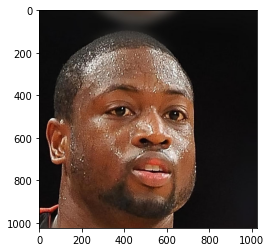

In [ ]:
#@title Pick image by number...
import matplotlib.pyplot as plt

import matplotlib.image as mpimg
import numpy as np
import os
def getTestImage(number):
  filename = sorted(os.listdir("data1024x1024"))[number]
  img=mpimg.imread('data1024x1024/'+filename)
  return img

import os
if not os.path.isdir("data1024x1024"):
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=11XKSCbFn0rs82xFyl0gtN-pHo3ipZbwc' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=11XKSCbFn0rs82xFyl0gtN-pHo3ipZbwc" -O data1024x1024_test.tar && rm -rf /tmp/cookies.txt
  !tar xvf data1024x1024_test.tar

imageNumber = 1665 #@param {type:"slider", min:0, max:2999, step:1}
image = getTestImage(imageNumber)
if image.dtype == "uint8":
  image = (image/255.).astype(np.float32)
plt.imshow(image,cmap="gray")
originalImage = image.copy()

### Upload your own image

In [ ]:
#@title Upload an image
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

desiredImageShape = (1024,1024,3)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
image = PIL.Image.open(fn)
print("Uploaded image:")
plt.figure()
plt.imshow(image)
plt.show()

if image.mode == "RGBA":
  image = image.convert("RGB")

image = image.resize(desiredImageShape[:2])
image = np.array(image)

if len(desiredImageShape) == 2 and len(image.shape) == 3:
  image = image.mean(2)
if len(desiredImageShape) == 3 and len(image.shape) == 2:
  raise Exception("Dataset is RGB, but your image is Gray. Try again!")

print("Uploaded image when resized:")
plt.figure()
plt.imshow(image,cmap="gray")
plt.show()
image = image/255.
originalImage = image.copy()

## Add NAs to the test image


### Add Block NAs

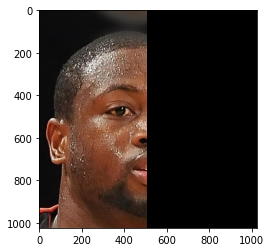

In [ ]:
#@title Add Block NAs
topLeftRow =  0#@param {type:"number"}
topLeftColumn =  512#@param {type:"integer"}
bottomRightRow =  1024#@param {type:"integer"}
bottomRightColumn =  1024#@param {type:"integer"}
import matplotlib.pyplot as plt

addNasBlock(image, topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn)
plt.imshow(image,cmap="gray")

### Add Single-Pixel NA

In [ ]:
#@title Add Single-Pixel NA
row =  20#@param {type:"number"}
column =  9#@param {type:"integer"}
import matplotlib.pyplot as plt

addNasPositions(image, [(row,column)])
plt.imshow(image,cmap="gray")

### Add Random NAs

In [ ]:
#@title Add Random NAs
probabilityOfSettingPixelToNa = 0.04 #@param {type:"slider", min:0, max:1, step:0.01}
addNasRandom(image,probabilityOfSettingPixelToNa)
import matplotlib.pyplot as plt
plt.imshow(image,cmap="gray")

## View image with NAs

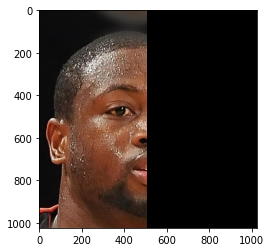

In [ ]:
#@title View image with NAs
plt.imshow(image,cmap="gray")

## Inpaint!

### Pick dataset, distribution, k=number of distributions

CPU times: user 2.11 s, sys: 300 ms, total: 2.41 s
Wall time: 2.04 s


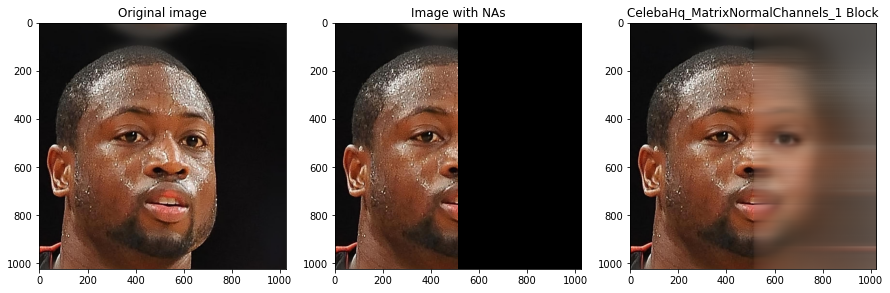

In [ ]:
#@title Pick data, distribution, k=number of distributions
%%time

imageWithNas = image
useModelFromMemory = False 
modelLocation = "web" #@param ["web", "your Google Drive account"]
dataName = "CelebaHq" 
distributionName = "MatrixNormalChannels" #@param ["MatrixNormalChannelsFaster", "MatrixNormalChannels"]
imputeABlockForMatrixNormalDistribution = True #@param {type:"boolean"}
k = 1 
resetInputedImageList = True #@param {type:"boolean"}
save = True #@param {type:"boolean"}

useModelFromMemory = False
if modelLocation == "web":
  import os
  directory = "serialized-models"
  if not os.path.isdir(directory):
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ZPCSyBjaFV0Xo_onnx1K49MyxJDlbVKn' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ZPCSyBjaFV0Xo_onnx1K49MyxJDlbVKn" -O serialized-models-20200911T112745Z-001.zip && rm -rf /tmp/cookies.txt
    !unzip serialized-models-20200911T112745Z-001.zip
  location = "serialized-models/"
elif modelLocation == "memory":
  useModelFromMemory = True
else:
  location = 'drive/My Drive/serialized-models/'

if not useModelFromMemory:
  if modelLocation != "web":
    from google.colab import drive
    drive.mount('drive')
  r = deserialize(dataName,distributionName,k,location=location)

if distributionName == "Normal" or distributionName == "NormalChannels":
  inpaintedImage = ImputeViaNormalDistributionChannels(
        fitDistribution=r,
        ifErrorReplaceByDistance=False,
        lambdaIdentity = 1e-6).impute(
        imageWithNas=imageWithNas,plot=False
    )
elif distributionName == "MatrixNormalChannelsFaster" or distributionName == "MatrixNormalChannels":
  if imputeABlockForMatrixNormalDistribution:
    inpaintedImage = ImputeViaMatrixNormalDistributionChannels(
        fitDistribution=r).imputeBlock(
              imageWithNas,
              topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn,
              plot=False
        )
  else:
    inpaintedImage = ImputeViaMatrixNormalDistributionChannels(
      fitDistribution=r).impute(
            imageWithNas,
            plot=False,
            iterations=10000,
            threshold=1e-6,
            optimizer = tf.train.AdamOptimizer(),
            verboseAt = 1000
      )
elif distributionName == "PixelCnn":
  inpaintedImage = ImputeViaPixelCnnDistribution(r).impute(
        imageWithNas,plot=False,iterations=1000,threshold=1e-6,optimizer=tf.train.AdamOptimizer(),verboseAt=100
    )

if resetInputedImageList:
  if 'inpaintedImages' in globals():
    del inpaintedImages
    del inpaintedTitles

if 'inpaintedImages' not in globals():
  inpaintedImages = []
  inpaintedTitles = []
inpaintedImages.append(inpaintedImage)
inpaintedTitles.append("{}_{}_{} {}".format(dataName,distributionName,k,"Block" if distributionName.startswith("Matrix") and imputeABlockForMatrixNormalDistribution else ""))

%matplotlib inline

fig, ax = plt.subplots(1,2+len(inpaintedImages),figsize=(15,15))
ax[0].title.set_text("Original image")
ax[0].imshow(originalImage,cmap="gray")
ax[1].title.set_text("Image with NAs")
ax[1].imshow(imageWithNas,cmap="gray")
for i in range(len(inpaintedImages)):
  ax[i+2].title.set_text(inpaintedTitles[i])
  ax[i+2].imshow(inpaintedImages[i],cmap="gray")

if save:
  plt.savefig('lastSaved.eps', format='eps')
  plt.savefig('lastSaved.jpg', format='jpg')